In [1]:
import os
import pandas as pd #load module for data manipulation

from scipy import stats #module for Stouffer's z-score method combined p-value calculation
import numpy as np #module to save data to file

import math

## load modules for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
cwd = os.getcwd() #gets current location of program file (.jpynb)

input_dir = cwd
output_dir = cwd + "\\" + "LEanalysis"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
column_names_list = list(pd.read_csv((input_dir + '\\' + "allpvalues2.txt"), sep="\t", header=0, nrows=1).columns)[1:]

In [4]:
pval_df = pd.read_csv((input_dir + '\\' + "allpvalues2.txt"), sep="\t", header = 0)

Tscore_df = pd.read_csv((input_dir + '\\' + "allTscores2.txt"), sep="\t", header = 0, index_col = 0)

In [5]:
#performs Stouffer's z-score method combined p-value calculation on pval_df
item_array = []
results_zscore_array = [] #collects stouffer's z-scores
results_pvalue_array = [] #collects combined p-values
results_total_array = []

for row_num, row_data in pval_df.iterrows():
    temp_y = list(pval_df.iloc[row_num])
    item = temp_y[0]
    temp_y.pop(0)
    combo_Zscore, combo_pvalue = stats.combine_pvalues(pvalues = temp_y, method = 'stouffer')
    combo_Zscore = (round(combo_Zscore, 1))
    combo_pvalue = format(combo_pvalue, '.2e')
    
    print(str(item) + ': Stouffers z-score is ' + str(combo_Zscore))
    print(str(item) + ': Combined p-value ' + str(combo_pvalue))
    print()
    
    item_array.append(item)
    results_zscore_array.append(combo_Zscore)
    results_pvalue_array.append(combo_pvalue)
    total = str(combo_Zscore) + ' (' + str(combo_pvalue) + ')'
    results_total_array.append(total)
    
#combine with Tscore data and save data to file

df_to_save = Tscore_df

temp_df_to_save = pd.DataFrame(np.column_stack([results_zscore_array, results_pvalue_array]),
                          columns=['Stouffers z-score', 'Combined p-value'],
                          index=item_array)

df_to_save['Stouffers z-score'] = temp_df_to_save['Stouffers z-score']
df_to_save['Combined p-value'] = temp_df_to_save['Combined p-value']

#df_to_save.sort_values(by=['Stouffers z-score'], axis=0, ascending=False, inplace=True)
df_to_save.to_csv(output_dir + "\combopvalresults.txt", sep ='\t', index=True)

GSE32863 LACvsadj1: Stouffers z-score is 16.4
GSE32863 LACvsadj1: Combined p-value 1.94e-60

GSE32863 LACvsadj2: Stouffers z-score is 17.4
GSE32863 LACvsadj2: Combined p-value 4.64e-68

GSE32863 LACvsadj: Stouffers z-score is 16.5
GSE32863 LACvsadj: Combined p-value 2.59e-61

GSE75037 LACvsadj: Stouffers z-score is 34.7
GSE75037 LACvsadj: Combined p-value 1.48e-263

GSE101684 LACvsadj: Stouffers z-score is 6.6
GSE101684 LACvsadj: Combined p-value 2.56e-11

GSE146689 LACvsadj: Stouffers z-score is 7.8
GSE146689 LACvsadj: Combined p-value 2.25e-15



In [6]:
new_pval_df = pval_df

new_pval_df.set_index('Gene', inplace=True)

new_pval_df['Stouffers z-score'] = temp_df_to_save['Stouffers z-score']
new_pval_df['Combined p-value'] = temp_df_to_save['Combined p-value']
new_pval_df.sort_values(by=['Stouffers z-score'], axis=0, ascending=False, inplace=True)

In [7]:
#convert pval_df from pval floats to * string significance markers for p<0.05 for heatmap annotation
working_pval_df = new_pval_df[column_names_list]

temp_value = ''
for col in working_pval_df:
    working_pval_df.loc[working_pval_df[col] < 0.05, col] = "o"
    working_pval_df.loc[working_pval_df[col] != "o", col] = " "

In [8]:
working_Tscore_df = df_to_save[column_names_list]

Tdf_all = working_Tscore_df

In [9]:
Pdf_all = working_pval_df

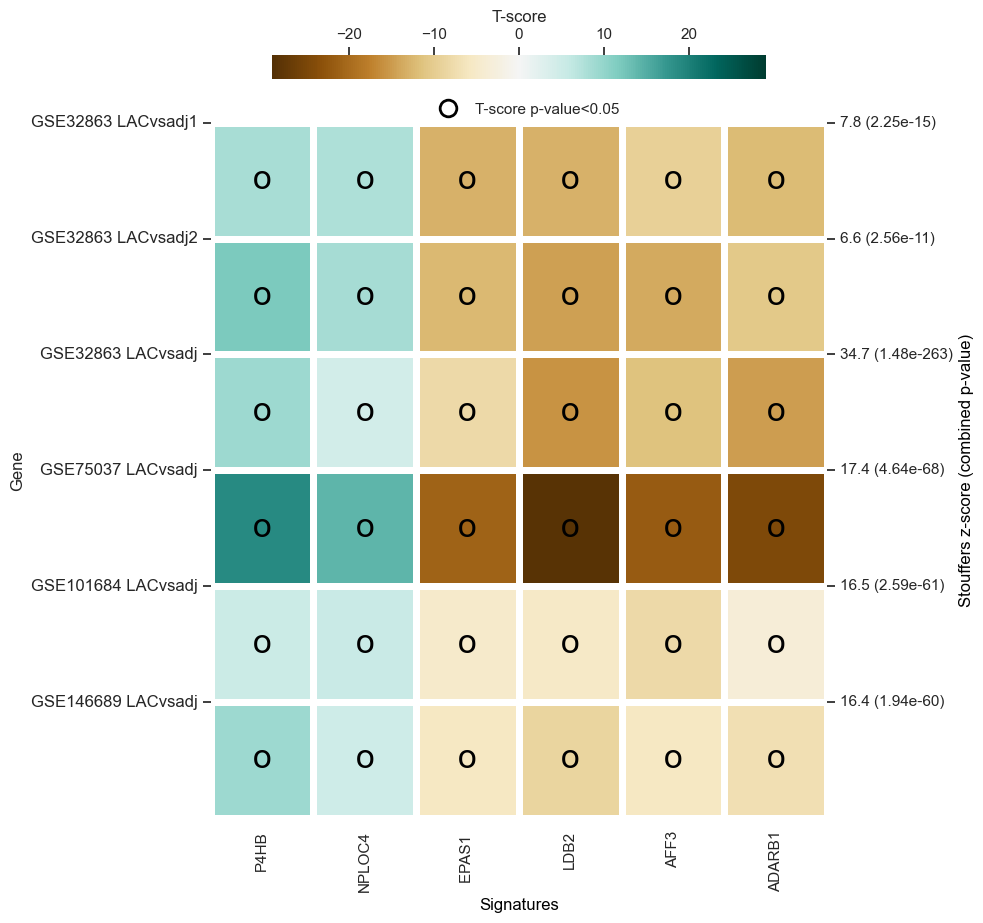

In [10]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}) #sets up white background for heat map

fig, ax = plt.subplots(figsize = (10, 10))

# Set color bar range
maxValues_all = Tdf_all.max().max()
minValues_all = Tdf_all.min().min()

cmap_set_point = max(abs(maxValues_all), abs(minValues_all))  # Use the maximum absolute value as the center point
cmap_set_point = math.ceil(cmap_set_point)

#define figure axes
ax = sns.heatmap(Tdf_all, cbar=False, center=0)
ax.set_xlabel('Signatures', color = 'black', fontsize=12)

ax2 = ax.twinx()

v1 = -cmap_set_point
v2 = cmap_set_point

ax2 = sns.heatmap(Tdf_all, linewidth = 5,
                 cmap = 'BrBG', fmt = 's', center = 0, cbar_kws = {'shrink': 0.8, 'label': 'T-score', 'location':"top"},
                 vmin = v1, vmax = v2, 
                 annot=Pdf_all,
                 annot_kws={'fontsize': 24, 'fontstyle': 'normal', 'color':'black',
                       'rotation': 'horizontal', "va": 'center'})

# Set y-tick locations explicitly for ax and ax2
ax.set_yticks(range(len(Tdf_all.index)))
ax2.set_yticks(range(len(Tdf_all.index)))

# Set y-tick labels for ax and ax2   
ax.set_yticklabels(labels=list(Tdf_all.index.values), rotation=0, fontsize=12)

y2_labels = list(new_pval_df['Stouffers z-score'])
new_y2_labels = []

count = 0
for i in y2_labels:
    temp_str = i + ' (' + new_pval_df['Combined p-value'][count] + ')'
    count = count + 1
    new_y2_labels.append(temp_str)

# Set y-tick locations explicitly for ax2
ax2.set_yticks(ax.get_yticks())

# Set y-tick labels for ax2   
ax2.set_yticklabels(labels=new_y2_labels, rotation=0)
ax2.set_ylabel('Stouffers z-score (combined p-value)', color = 'black', fontsize=12)

# Set x-tick labels rotation to vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

legend_star = mlines.Line2D([], [], color='black', linestyle="None", markeredgewidth=2, fillstyle="none", marker='o', label='T-score p-value<0.05')
plt.legend(handles=[legend_star], markerscale=2, bbox_to_anchor=(0.35, 1), loc=3, borderaxespad=0, frameon=False)

plt.tight_layout()
fig = ax.get_figure()
fig.savefig(output_dir + "\StouffersHeatMap.jpg", format = 'jpg', dpi = 300)